# Final Project
### Môn học: CSC17104 - Lập trình cho Khoa học dữ liệu
****

**Đây là File Notebook sample, chưa hoàn thiện, nên chỉ xem để biết Dữ liệu chọn có đáp ứng hết các task trong này không (ngoài các yêu cầu đã ghi ở phần tìm hiểu ha). Khi bắt đầu thực hiện sẽ gửi File Notebook để tự làm rồi up github.**

**Nhóm 26**
<table style='float:left;'>
    <tr>
        <th style='text-align:center;'>MSSV</th>
        <th style='text-align:center;'>Họ và Tên</th>
        <th style='text-align:center;'>Mức độ hoàn thành(%)</th>
        <th style='text-align:center;'>Nhiệm vụ</th>
    </tr>
    <tr>
        <td style='text-align:center;'>21120178</td>
        <td style='text-align:left;'>Văn Bá Bảo Huy</td>
        <td style='text-align:center;'>Mức độ hoàn thành</td>
        <td style='text-align:left;'>Nhiệm vụ</td>
    </tr>
    <tr>
        <td style='text-align:center;'>21120071</td>
        <td style='text-align:left;'>Nguyễn Thị Thanh Hoa</td>
        <td style='text-align:center;'>Mức độ hoàn thành</td>
        <td style='text-align:left;'>Nhiệm vụ</td>
    </tr>
    <tr>
        <td style='text-align:center;'>21120174</td>
        <td style='text-align:left;'>Nguyễn Thị Gái</td>
        <td style='text-align:center;'>Mức độ hoàn thành</td>
        <td style='text-align:left;'>Nhiệm vụ</td>
    </tr>
</table>

### Environment check & Import nescessary packages

In [1]:
import sys
sys.executable
!pip install -q kaggle

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from collections import Counter
import datetime
import statistics
import seaborn as sns
from matplotlib import cycler

# **Phase 1**: Collecting Data

**Dataset**: Movies Daily Update Dataset<br>
**Kaggle**: https://www.kaggle.com/datasets/akshaypawar7/millions-of-movies

In [3]:
# #Download data from Kaggle with api-key
# !mkdir ~/.kaggle
# !touch ~/.kaggle/kaggle.json
# api_json = {"username":"tyzenr","key":"08b25d2b177116a2cb7dfddc38ab964b"}
# with open('/root/.kaggle/kaggle.json', 'w') as file:
#     json.dump(api_json, file)
# !chmod 600 ~/.kaggle/kaggle.json
# import kaggle
# kaggle.api.authenticate()
# kaggle.api.dataset_download_files('akshaypawar7/millions-of-movies', path='.', unzip=True)

**1. Dữ liệu về chủ đề gì? Nguồn dữ liệu?**<br>
- Chủ đề dữ liệu: Bộ dữ liệu của hơn 700.000 bộ phim trong tập dữ liệu TMDB.<br>
- Nguồn dữ liệu: Kaggle
<br>

**2. Kiểm tra vấn đề bản quyền của tập dữ liệu.**<br>
- Answer
<br>

**3. Tác giả của tập dữ liệu đã thu thập bằng cách nào?** <br>
- Answer
<br>

# **Phase 2**: Exploring Data - Preprocessing

### 2.0 Đọc dữ liệu

In [4]:
df = pd.read_csv("TMDB_movie_dataset_v11.csv")
df.head(3)

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,...,original_language,original_title,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,...,en,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,/oYuLEt3zVCKq57qu2F8dT7NIa6f.jpg,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili"
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,False,/pbrkL804c8yAv3zBZR4QPEafpAR.jpg,...,en,Interstellar,The adventures of a group of explorers who mak...,140.241,/gEU2QniE6E77NI6lCU6MxlNBvIx.jpg,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English
2,155,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,False,/nMKdUUepR0i5zn0y1T4CsSB5chy.jpg,...,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,/qJ2tW6WMUDux911r6m7haRef0WH.jpg,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin"


### 2.1 Có bao nhiêu hàng và bao nhiêu cột?

###  2.2 Ý nghĩa của mỗi hàng là gì?

### 2.3 Có 'hàng trùng lặp' không?

In [5]:
print(f"Dữ liệu trên có {df.duplicated().sum()} dòng bị lặp")

Dữ liệu trên có 5 dòng bị lặp


### 2.4 Ý nghĩa của từng cột là gì?

In [6]:
df.columns

Index(['id', 'title', 'vote_average', 'vote_count', 'status', 'release_date',
       'revenue', 'runtime', 'adult', 'backdrop_path', 'budget', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'tagline', 'genres',
       'production_companies', 'production_countries', 'spoken_languages'],
      dtype='object')

### 2.5 Kiểu dữ liệu hiện tại của mỗi cột là gì? Có cột nào có kiểu dữ liệu không phù hợp không?

### 2.6 Với mỗi cột số, các giá trị được phân bố như thế nào?
- Phần trăm giá trị còn thiếu là bao nhiêu?
- Tối thiểu? tối đa? Chúng có bất thường không?

Các cột số có trong dữ liệu là: `id`, `popularity`, `budget`, `revenue`, `runtime`, `vote_average`, `vote_count`.
Để kiểm tra các giá trị phân bố, ta tạo một DataFrame `nume_col_df` có chứa các cột thuộc kiểu numeric và được thống kê với các số liệu về:

`missing_ratio`: Tỉ lệ các giá trị thiếu trong cột.

`min`: Giá trị nhỏ nhất trong cột.

`max`: Giá trị lớn nhất trong cột.

In [20]:
numeric_df = df.select_dtypes(include=['number'])
nume_col_df = pd.DataFrame( index=["missing_ratio", "min", "max"], columns=numeric_df.columns)

nume_col_df.loc["missing_ratio"] = (numeric_df.isna().sum() / numeric_df.size) *100
nume_col_df.loc["min"] = np.min(numeric_df)
nume_col_df.loc["max"] = np.max(numeric_df)

nume_col_df

,id,vote_average,vote_count,revenue,runtime,budget,popularity
missing_ratio,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,2923706026.0,2923706026.0,2923706026.0,2923706026.0,2923706026.0,2923706026.0,2923706026.0


Không có giá trị bị thiếu trong các cột số. Các giá trị `min` và `max` không có gì bất thường.

### 2.7 Với mỗi cột phân loại, các giá trị được phân bổ như thế nào?
- Phần trăm giá trị còn thiếu là bao nhiêu?
- Có bao nhiêu giá trị khác nhau? Hiển thị một số giá trị đó.
- Chúng có bất thường không?

# **Phase 3**: Preprocessing & Asking Meaningful questions
Yêu cầu:
- Số lượng câu hỏi đặt ra cần lớn hơn hoặc bằng số lượng thành viên ($\ge 3$)
- Câu hỏi đặt ra cần có ý nghĩa (tác dụng của việc tìm kiếm câu trả lời cho câu hỏi đó) và không được quá dễ 🙂
- Chú ý đến chất lượng của từng câu hỏi, không phải số lượng câu hỏi.
- Trong file Notebook, với mỗi câu hỏi cần thể hiện được:
    - Nội dung câu hỏi
    - Ý nghĩa của câu hỏi

## **3.0** Preprocessing

In [8]:
df = df.dropna(subset=['release_date','genres','revenue'])


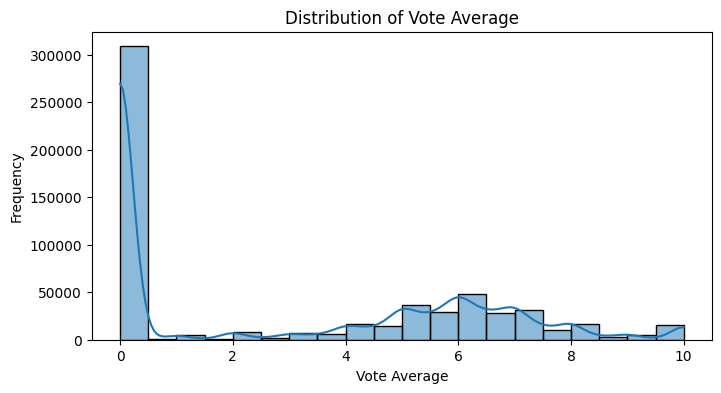

In [80]:
plt.figure(figsize=(8, 4))
sns.histplot(df['vote_average'], bins=20, kde=True)
plt.title('Distribution of Vote Average')
plt.xlabel('Vote Average')
plt.ylabel('Frequency')
plt.show()

## **3.1** Asking meaningful question

<table style='float:left;'>
    <tr>
        <th style='text-align:center;'>STT</th>
        <th style='text-align:center;'>Nội dung</th>
        <th style='text-align:center;'>Trình bày</th>
    </tr>
    <tr>
        <td style='text-align:center;'>Câu 1</td>
        <td style='text-align:left;'>Nội dung</td>
        <td style='text-align:center;'><a href='#cauhoi_1'>C1</a></td>
    </tr>
    <tr>
        <td style='text-align:center;'>Câu 2</td>
        <td style='text-align:left;'>Nội dung</td>
        <td style='text-align:center;'><a href='#cauhoi_2'>C2</a></td>
    </tr>
    <tr>
        <td style='text-align:center;'>Câu 3</td>
        <td style='text-align:left;'>Nội dung</td>
        <td style='text-align:center;'><a href='#cauhoi_3'>C3</a></td>
    </tr>
</table>

# **Phase 4**: Analyzing data to answer each question

### **Câu hỏi 1**: ghi nội dung ở đây<a name="cauhoi_1"></a>

**Ý nghĩa:**

### **Câu hỏi 2**: Những yếu tố nào là đặc trưng của 1 bộ phim có doanh thu cao?  <a name="cauhoi_2"></a>

**Ý nghĩa:** 
- Giúp chúng ta xác định được để có được 1 bộ phim có doanh thu cao thì những yếu tố ảnh hưởng là gì. 
- Điều này cung cấp thông tin quan trọng cho ngành công nghiệp điện ảnh để có thể tối ưu hóa chiến lược sản xuất và quảng cáo, tập trung vào việc tạo ra nội dung thu hút và thuận lợi nhất để thu hút đối tượng khán giả và đạt được doanh thu cao.


**Quy trình:**
- Loại bỏ dữ liệu không có doanh thu (vì 1 số lý do doanh thu không được cập nhật).
- Xác định ngưỡng doanh thu cao
- Phân tích tương quan và trực quan hoá
- Đưa ra nhận xét và kết luận

Trong bộ dữ liệu có rất nhiều bộ phim có doanh thu bằng 0. Để tính toán một cách hiệu quả cho câu hỏi trên đầu tiên ta sẽ tiến hành loại bỏ các cột này.

In [9]:
positive_revenue_df = df.loc[df['revenue'] > 0]

In [10]:
positive_revenue_df['revenue'].describe()

count    1.766100e+04
mean     4.070884e+07
std      1.229813e+08
min      1.000000e+00
25%      1.871450e+05
50%      3.355000e+06
75%      2.426157e+07
max      2.923706e+09
Name: revenue, dtype: float64

74.99575335484967   25.00424664515033


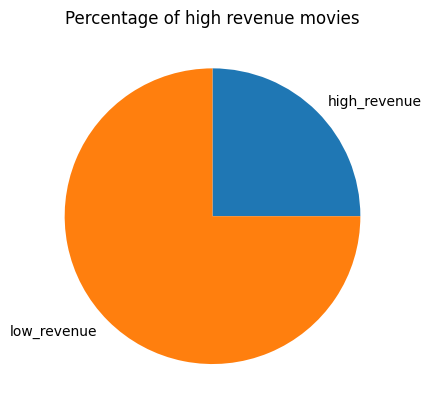

In [11]:
high_revenue = positive_revenue_df['revenue'].quantile(.75)
high_revenue_percent = positive_revenue_df['revenue'][positive_revenue_df['revenue'] >= high_revenue].count() / positive_revenue_df.shape[0] *100

high_revenue_df = positive_revenue_df[positive_revenue_df['revenue'] >= high_revenue]

plt.pie([high_revenue_percent, 100-high_revenue_percent], labels = ['high_revenue', 'low_revenue'], startangle = 90, counterclock = False)
plt.title('Percentage of high revenue movies');
print(100-high_revenue_percent, ' ', high_revenue_percent)

Trước khi phân tích kỹ hơn thì ta sẽ có tổng quan về tỷ lệ phim có doanh thu cao(được tính theo phân vị 75%):
- Tỷ lệ phim có doanh thu cao là 25%
- Tỷ lệ phim doanh thu thấp là 75%

Ta sử dụng **corr()** để tính giá trị tương quan và **searbon** để vẽ biểu đồ mối tương quan giữa các yếu tố khác đến doanh thu trong những bộ phim có doanh thu cao. Trong đó: 
- 1: Tương quan hoàn toàn tích cực.
- 0: Không có tương quan tuyến tính.
- -1: Tương quan hoàn toàn tiêu cực.

Correlation between revenue and vote_average: 0.17
Correlation between revenue and vote_count: 0.69
Correlation between revenue and runtime: 0.17
Correlation between revenue and budget: 0.67
Correlation between revenue and popularity: 0.18


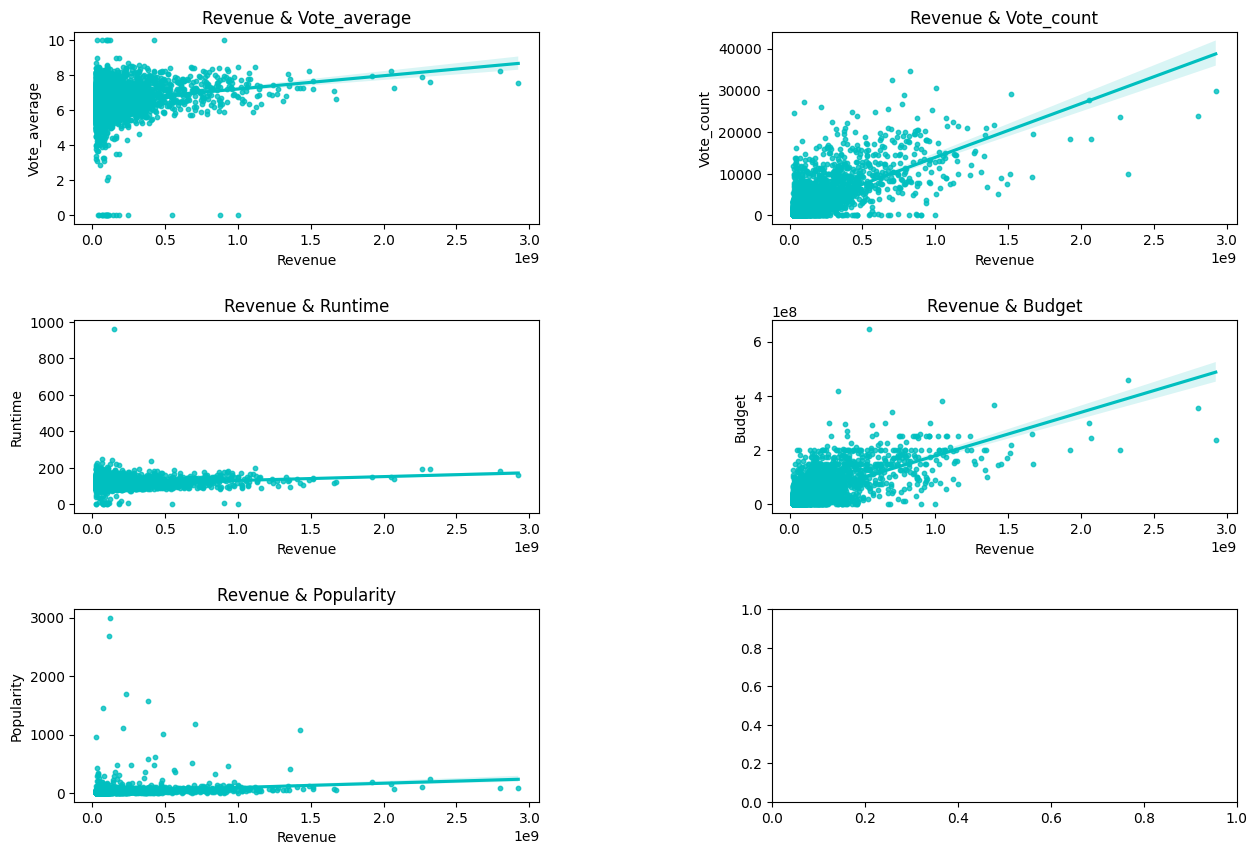

In [12]:
features = high_revenue_df.select_dtypes(include=['number']).columns.tolist()
features.remove('revenue')
features.remove('id')


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

axes = axes.flatten()

for i, feature in enumerate(features):
    sns.regplot(x=high_revenue_df['revenue'], y=high_revenue_df[feature], color='c', scatter_kws={'s': 10}, ax=axes[i])
    
    axes[i].set_title(f"Revenue & {feature.capitalize()}", fontsize=12)
    axes[i].set_xlabel("Revenue", fontsize=10)
    axes[i].set_ylabel(feature.capitalize(), fontsize=10)

    correlation = high_revenue_df['revenue'].corr(high_revenue_df[feature])
    print(f"Correlation between revenue and {feature}: {correlation:.2f}")

plt.show()

Dựa trên giá trị mối tương quan được tính, ta có thể đưa ra một số nhận xét về mức độ tương quan giữa doanh thu và các thuộc tính số khác như:

- **Điểm đánh giá trung bình (vote_average)**: Mối tương quan là 0.11, cho thấy có một sự tương quan tích cực nhẹ. Tuy nhiên, mối liên kết này không mạnh.

- **Số lượng phiếu bầu (vote_count)**: Có một mối tương quan đáng kể (0.67) giữa số lượng phiếu bầu và doanh thu. Điều này có thể chỉ ra rằng các bộ phim có số lượng phiếu bầu lớn thường có doanh thu cao.

- **Thời lượng (runtime)**: Mối tương quan là 0.13, cho thấy mối liên kết nhẹ giữa thời lượng và doanh thu.

- **Ngân sách (budget)**: Có một mối tương quan đáng kể (0.65) giữa ngân sách và doanh thu. Điều này có ý nghĩa, vì có thể dự đoán rằng các bộ phim với ngân sách lớn hơn thường có khả năng có doanh thu cao hơn.

- **Độ phổ biến (popularity)**: Có một mối tương quan nhẹ (0.17) giữa độ phổ biến và doanh thu.

Đối với rating của các bộ phim tuy không có sự tuyến tính giữa các bộ phim có doanh thu cao và rating nhưng khi so sánh biểu đồ, chúng ta có thể thấy đối với các bộ phim có doanh thu cao thì mức độ phim bị đánh giá thấp ít hơn rất nhiều so với các bộ phim có doanh thu thấp.

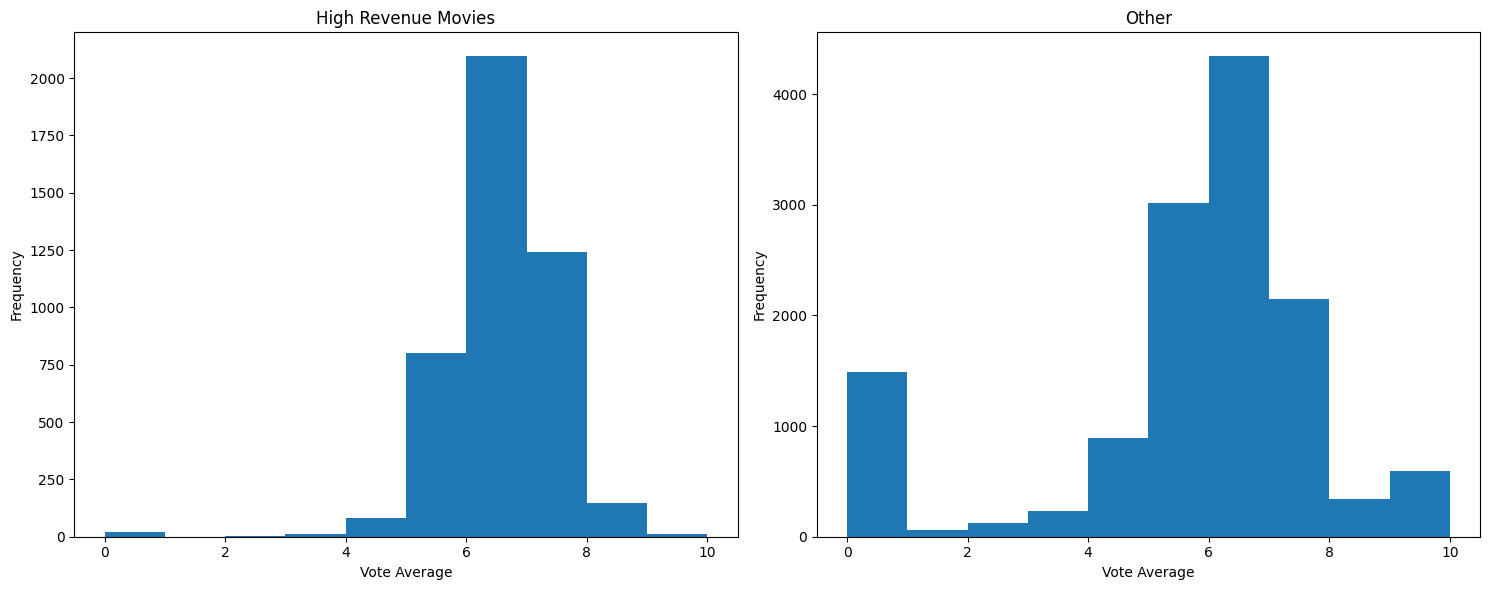

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

other_revenue_df = positive_revenue_df[positive_revenue_df['revenue'] <= high_revenue]

axes[0].hist(high_revenue_df['vote_average'])
axes[0].set_title('High Revenue Movies')
axes[0].set_xlabel('Vote Average')
axes[0].set_ylabel('Frequency')

axes[1].hist(other_revenue_df['vote_average'])
axes[1].set_title('Other')
axes[1].set_xlabel('Vote Average')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### **Câu hỏi 3**: 5 công ty có doanh thu lớn nhất tập trung sản xuất các thể loại nào? <a name="cauhoi_3"></a>

**Ý nghĩa:**
Các công ty có doanh thu lớn là những công ty đứng đầu nền công nghiệp điện ảnh, việc phân tích sự phân bố của các thể loại của các công ty này có thể giúp ta có những nhận định sau:
- Hiểu được thị trường và sở thích của khán giả của các công ty hàng đầu có thể giúp ngành công nghiệp điện ảnh tập trung vào sản xuất những thể loại nào để tối ưu hóa lợi nhuận.
- Cung cấp thông tin chiến lược cho các nhà sản xuất về việc chọn lựa thể loại nào có thể mang lại doanh thu cao khi hợp tác với các công ty lớn.
- Hiểu rõ về sự phân bố doanh thu có thể giúp các công ty đảm bảo đa dạng hóa sản phẩm của họ. Việc sản xuất các loại phim khác nhau dựa trên xu hướng thị trường có thể giảm rủi ro và tăng khả năng thu hút đối tượng khán giả đa dạng.
- Sự hiểu biết về thị trường thể loại giúp chỉ đạo nghiên cứu và phát triển. Các nhà sản xuất có thể dựa vào thông tin này để phát triển những dự án mới phù hợp với sở thích và yêu cầu của thị trường.

**Quy trình:**
- Loại bỏ dữ liệu không có doanh thu (vì 1 số lý do doanh thu không được cập nhật).
- Tách cột `production_companies` để lấy ra danh sách các công ty
- Tách cột `genres` để lấy ra danh sách thể loại ứng với công ty
- Nhóm dữ liệu lại và lấy ra top 6 công ty có doanh thu cao nhất
- Vẽ biểu đồ  Pie Chart cho sự phân bố thể loại của từng công ty
- Nhận xét và đánh giá

In [78]:
companies_df = df[df['revenue'] > 0 ]

companies_df['production_companies'] = df['production_companies'].apply(lambda x: re.split(', |,', str(x)))
companies_df['production_companies'] = companies_df['production_companies'].apply(lambda x: [] if str(x) == "['nan']" else x)

companies_df['genres'] = df['genres'].apply(lambda x: re.split(', |,', str(x)))
companies_df['genres'] = companies_df['genres'].apply(lambda x: [] if str(x) == "['nan']" else x)

new_df = pd.DataFrame({
    'production_company': companies_df['production_companies'].explode().reset_index(drop=True),
    'revenue': companies_df['revenue'].explode().reset_index(drop=True),
    'genre': companies_df['genres'].explode().reset_index(drop=True)
})

top_countries = new_df.groupby('production_company')['revenue'].sum().reset_index()

top_countries = top_countries.sort_values(by='revenue', ascending=False).head(6)

top_countries_genres = new_df[new_df['production_company'].isin(top_countries['production_company'])]

/tmp/ipykernel_522/1579302202.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  companies_df['production_companies'] = df['production_companies'].apply(lambda x: re.split(', |,', str(x)))
/tmp/ipykernel_522/1579302202.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  companies_df['production_companies'] = companies_df['production_companies'].apply(lambda x: [] if str(x) == "['nan']" else x)
/tmp/ipykernel_522/1579302202.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

<Figure size 1200x800 with 0 Axes>

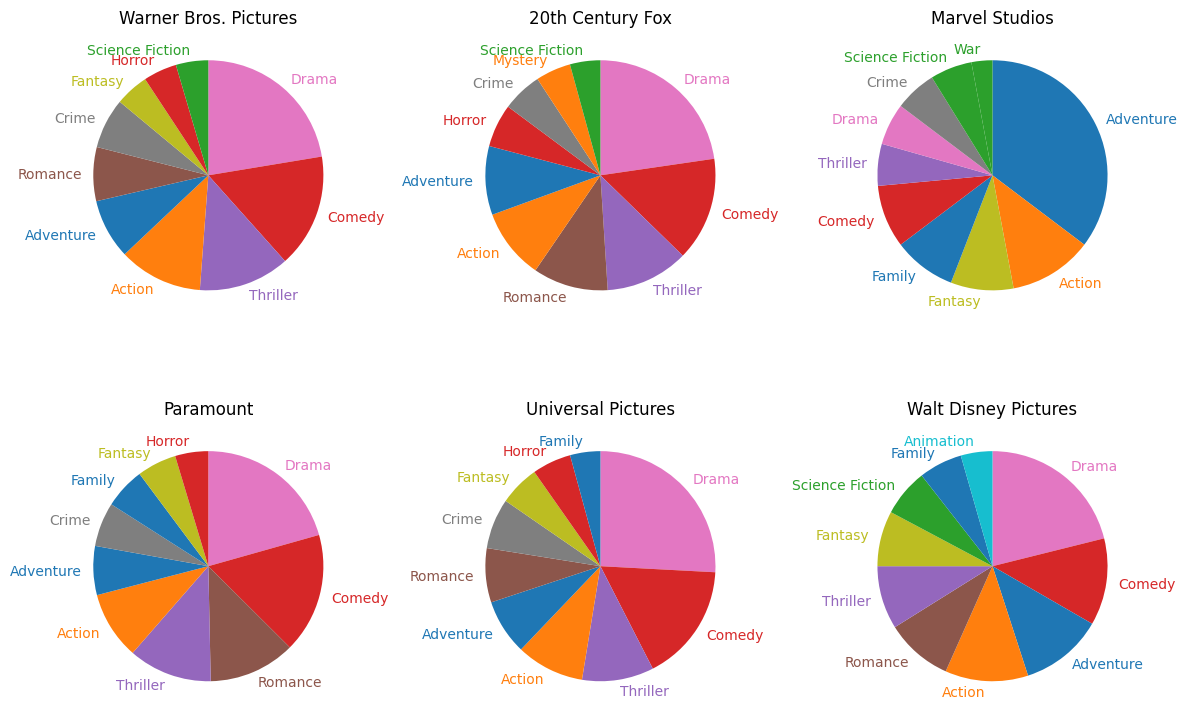

In [75]:
plt.figure(figsize=(12, 8))

all_genres = top_countries_genres['genre'].unique()
num_companies = len(top_countries_genres['production_company'].unique())

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

genre_palette = sns.color_palette('tab10', n_colors=len(all_genres), desat=1)
genre_color_mapping = dict(zip(all_genres, genre_palette))

for i, company in enumerate(top_countries_genres['production_company'].unique()):
    company_data = top_countries_genres[top_countries_genres['production_company'] == company]
    
    genre_counts = company_data['genre'].value_counts()
    genre_counts = genre_counts.reindex(all_genres, fill_value=0)
    genre_counts = genre_counts.sort_values(ascending=False)
    
    top_10_genres = genre_counts.head(10)
    
    colors = [genre_color_mapping.get(genre, 'gray') for genre in top_10_genres.index]
    wedges, texts, autotexts = axes[i].pie(top_10_genres, labels=None, autopct='', startangle=90, counterclock=False, colors=colors)
    
    for text, autotext, label, color in zip(texts, autotexts, top_10_genres.index, colors):
        text.set_text(label)
        text.set_color(color)
    
    axes[i].set_title(f'{company}')

plt.tight_layout()
plt.show()


Dựa trên biểu đồ ta có thể đưa ra một số nhận xét sau: 
- Các công ty đều có sự đa dạng trong các thể loại phim, giúp đáp ứng nhu cầu đa dạng của khán giả. 
- Các công ty có mức độ tương đồng về các loại phim phổ biến. Riêng `Marvel Studios` có sự nổi trội về thể loại `Adventure` hơn hẳn. 

# **Phase 5**: Reflection

## 5.0 Team members

**Văn Bá Bảo Huy**
- Khó khăn:
- Điều đã học được:

**Nguyễn Thị Gái**
- Khó khăn: Tìm dữ liệu có thể đáp ứng được việc đặt 
- Điều đã học được:

**Nguyễn Thị Thanh Hoa**
- Khó khăn:
- Điều đã học được:

## 5.1 Team

Nếu có nhiều thời gian hơn, nhóm sẽ ...